In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn import neighbors, metrics
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [2]:
# Import de tous mes dataframes

simple_data = pd.read_excel("../CSV-Excels/simple_data.xlsx", index_col=0)
large_simple_data = pd.read_excel("../CSV-Excels/large_simple_data.xlsx", index_col=0)
medium_data = pd.read_excel("../CSV-Excels/medium_data.xlsx", index_col=0)
large_medium_data = pd.read_excel("../CSV-Excels/large_medium_data.xlsx", index_col=0)
simple_data_with_energy_score = pd.read_excel("../CSV-Excels/simple_data_with_energy_score.xlsx", index_col=0)
medium_data_with_energy_score = pd.read_excel("../CSV-Excels/medium_data_with_energy_score.xlsx", index_col=0)
full_data_with_energy_score = pd.read_excel("../CSV-Excels/full_data_with_energy_score.xlsx", index_col=0)
full_data_without_energy_score = full_data_with_energy_score.drop(columns=['ENERGYSTARScore'])

In [3]:
# Dernier nettoyage

full_data_with_energy_score = full_data_with_energy_score[(full_data_with_energy_score["PrimaryPropertyType"] != 'Low-Rise Multifamily') & (full_data_with_energy_score["LargestPropertyUseType"] != 'Multifamily Housing')]
full_data_without_energy_score = full_data_without_energy_score[(full_data_without_energy_score["PrimaryPropertyType"] != 'Low-Rise Multifamily') & (full_data_without_energy_score["LargestPropertyUseType"] != 'Multifamily Housing')]
large_medium_data = large_medium_data[large_medium_data["PrimaryPropertyType"] != 'Low-Rise Multifamily']
large_simple_data = large_simple_data[large_simple_data["PrimaryPropertyType"] != 'Low-Rise Multifamily']

In [4]:
# One hot encoding dataframes avec des variables catégorielles

full_data_without_energy_score = pd.get_dummies(full_data_without_energy_score)
full_data_with_energy_score = pd.get_dummies(full_data_with_energy_score)
large_simple_data = pd.get_dummies(large_simple_data)
large_medium_data = pd.get_dummies(large_medium_data)

In [2]:
# Split data in train set and test set

def split_data(dataframe, target_variable, train_sizing):
    X = dataframe[dataframe.columns.difference(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'])].values
    y = dataframe[target_variable].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_sizing, random_state=33530)
    return X_train, X_test, y_train, y_test

In [3]:
# Scaler uniquement sur les variables quantitatives spécifiées 

def scaler_fit(scaler, df):
    if df.name == 'simple_data' or df.name == 'large_simple_data':
        df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']] = scaler.fit_transform(df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']])
    elif df.name == 'medium_data' or df.name == 'large_medium_data':
        df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']] = scaler.fit_transform(df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']])
    elif df.name == 'simple_data_with_energy_score':
        df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']] = scaler.fit_transform(df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']])
    elif df.name == 'medium_data_with_energy_score':
        df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']] = scaler.fit_transform(df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']])
    elif df.name == 'full_data_with_energy_score':
        df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = scaler.fit_transform(df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']])
    elif df.name == 'full_data_without_energy_score':
        df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = scaler.fit_transform(df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']])
    return df

In [7]:
# random regressor

def random_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test):

    y_pred_random = np.random.randint(np.min(y_train), np.max(y_train), y_test.shape)
    random_rmse = metrics.mean_squared_error(y_test, y_pred_random, squared=False)
    random_r2 = metrics.r2_score(y_test, y_pred_random)
    random_max_error = metrics.max_error(y_test, y_pred_random)
    
    return {'dataset': dataframe.name, 'model': 'Random', 'tested_hyperparameters': 'aucun', 'RMSE': random_rmse,
            'best_hyperparameters': 'aucun', 'r2_test': random_r2, 'max_error': random_max_error}

In [8]:
# dummy regressor

def dummy_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test):
    
    dum = DummyRegressor(strategy='mean')
    dum.fit(X_train_scaled, y_train)
    y_pred_dum = dum.predict(X_test_scaled)
    
    rmse = metrics.mean_squared_error(y_test, y_pred_dum, squared=False)
    r2 = metrics.r2_score(y_test, y_pred_dum)
    max_error = metrics.max_error(y_test, y_pred_dum)
    
    return {'dataset': dataframe.name, 'model': 'DummyRegressor', 'best_hyperparameters': 'aucun',
            'tested_hyperparameters': 'aucun', 'RMSE': rmse, 'max_error': max_error, 'r2_test': r2}

In [9]:
# knn regressor

def knn_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):
    
    grid = GridSearchCV(
        neighbors.KNeighborsRegressor(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'KnnRegressor', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [10]:
def ridge_regression(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):
    
    grid = GridSearchCV(
        Ridge(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan

    return {'dataset': dataframe.name, 'model': 'Ridge Regression', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [11]:
def lasso_regression(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        Lasso(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'Lasso Regression', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [12]:
def kernel_ridge(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        KernelRidge(kernel='rbf'),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'Kernel Ridge Regression', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [13]:
def kernel_svr(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        SVR(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'Kernel SVR', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [14]:
def mlp_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        MLPRegressor(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'MLP Regressor', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [15]:
def gboost_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        GradientBoostingRegressor(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    arr = grid_results['mean_test_score'][grid_results['mean_test_score'] > -2]
    max_score = np.amax(arr)
    index_max_score = np.where(grid_results['mean_test_score'] == max_score)
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'GBoost Regressor', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [5]:
# Variables

TARGET = "TotalGHGEmissions"
TRAIN_SIZE = 0.7
# df_list = [simple_data, large_simple_data, medium_data, large_medium_data, simple_data_with_energy_score,
#            medium_data_with_energy_score, full_data_without_energy_score, full_data_with_energy_score]

In [17]:
# Set name for each dataframe

full_data_without_energy_score.name = 'full_data_without_energy_score'
full_data_with_energy_score.name = 'full_data_with_energy_score'
simple_data.name = 'simple_data'
large_simple_data.name = 'large_simple_data'
medium_data.name = 'medium_data'
large_medium_data.name = 'large_medium_data'
simple_data_with_energy_score.name = 'simple_data_with_energy_score'
medium_data_with_energy_score.name = 'medium_data_with_energy_score'

In [18]:
# Création du dataframe final qui stocke les résultats des modèles

d = pd.DataFrame(columns = [ "dataset", "scaler_used", "model", "tested_hyperparameters",
                            "best_hyperparameters", "r2_trainset", "r2_validation_set",
                            "r2_test", "RMSE", "max_error" 
                           ])

scaler_counter = 0
start_row = 0
end_row = 9
string_scaler_list = ['StandardScaler', 'RobustScaler', 'MinMaxScaler']
scaler_list = [StandardScaler(), RobustScaler(), MinMaxScaler()]
for df in df_list:
    for scaler in scaler_list:
        scaled_dataframe = scaler_fit(scaler, df)
        X_train_scaled, X_test_scaled, y_train, y_test = split_data(scaled_dataframe, TARGET, TRAIN_SIZE)
        d = d.append([
            random_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test),
            dummy_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test),
            knn_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test, {'n_neighbors': [3,5,7,9,11,13,15]}, 'r2'),
            ridge_regression(df, X_train_scaled, X_test_scaled, y_train, y_test, {'alpha': np.logspace(-3, 3, 7), 'max_iter': [10000], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}, 'r2'),
            lasso_regression(df, X_train_scaled, X_test_scaled, y_train, y_test, {'alpha': np.logspace(-3, 3, 7), 'max_iter': [5000], 'selection': ['cyclic', 'random'], 'random_state': [33530]}, 'r2'),
            kernel_ridge(df, X_train_scaled, X_test_scaled, y_train, y_test, {'alpha': np.logspace(-3, 3, 7), 'gamma': np.logspace(-2, 2, 5)}, 'r2'),
            kernel_svr(df, X_train_scaled, X_test_scaled, y_train, y_test, {'C':  np.logspace(-1, 2, 3), 'gamma': np.logspace(-1, 1, 3), 'kernel': ['rbf']}, 'r2'),
            mlp_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test, {'alpha': np.logspace(-2, 1, 4), 'learning_rate_init': np.logspace(-3,-2,2), 'learning_rate': ['constant'], 'hidden_layer_sizes': [(20,20)], 'activation': ['relu'], 'solver': ['adam'], 'random_state': [33530], 'max_iter': [2000]}, 'r2'),
            gboost_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test, {'n_estimators': [100,150], 'learning_rate': [0.03,0.01], 'loss': ['huber'], 'max_depth': [3,6], 'random_state': [33530]}, 'r2')
        ], ignore_index=True)
        d.iloc[start_row:end_row,1] = string_scaler_list[scaler_counter]
        scaler_counter += 1
        start_row += 9
        end_row += 9
    scaler_counter = 0

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151636299.12354168, tolerance: 55105.548659862056
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151636025.87628382, tolerance: 55105.548659862056
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151651888.58202446, tolerance: 55105.548659862056
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1925525.3888145722, tolerance: 53318.06848899999
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153712.1158687845, tolerance: 37578.62010448936
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155982.3654374443, tolerance: 22357.960533338617
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 990452.7483885884, tolerance: 48819.916354174435
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 795587.0816556662, tolerance: 53550.05332048
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 870259.6184595302, tolerance: 37578.62010448936
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278871.76819850504, tolerance: 37578.62010448936
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4676757.3915543705, tolerance: 22357.960533338617
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1949480.1920514256, tolerance: 53318.06848899999
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4043239.46171733, tolerance: 53318.06848899999
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8040469.474440202, tolerance: 48819.916354174435
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18544736.91533066, tolerance: 53550.05332048
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1709242.7909268364, tolerance: 37578.62010448936
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5595276.433742512, tolerance: 53318.06848899999
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8061317.373407971, tolerance: 48819.916354174435
  model = cd_fast.enet_coordinate_descent(
/home/kilian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

In [19]:
d

,dataset,scaler_used,model,tested_hyperparameters,best_hyperparameters,r2_trainset,r2_validation_set,r2_test,RMSE,max_error
0,simple_data,StandardScaler,Random,aucun,aucun,NaN,NaN,-170.091990,9641.016229,16844.320000
1,simple_data,StandardScaler,DummyRegressor,aucun,aucun,NaN,NaN,-0.000044,737.084982,12115.021782
2,simple_data,StandardScaler,KnnRegressor,"{'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}",{'n_neighbors': 7},0.266166,-0.028482,0.338903,599.294880,8417.077143
3,simple_data,StandardScaler,Ridge Regression,"{'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+0...","{'alpha': 1000.0, 'max_iter': 10000, 'solver':...",0.258402,0.261109,0.176867,668.718100,10995.731812
4,simple_data,StandardScaler,Lasso Regression,"{'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+0...","{'alpha': 100.0, 'max_iter': 5000, 'random_sta...",0.283620,0.294369,0.219838,651.028951,10566.616621
...,...,...,...,...,...,...,...,...,...,...
211,full_data_with_energy_score,MinMaxScaler,Lasso Regression,"{'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+0...","{'alpha': 1000.0, 'max_iter': 5000, 'random_st...",0.001490,-0.152554,0.002207,818.678948,10527.053963
212,full_data_with_energy_score,MinMaxScaler,Kernel Ridge Regression,"{'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+0...","{'alpha': 100.0, 'gamma': 0.01}",0.000746,-0.043173,-0.012545,824.708669,10561.320942
213,full_data_with_energy_score,MinMaxScaler,Kernel SVR,"{'C': array([ 0.1 , 3.16227766, 100. ...","{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.015793,0.015916,-0.004772,821.537301,10582.758876
214,full_data_with_energy_score,MinMaxScaler,MLP Regressor,"{'alpha': array([ 0.01, 0.1 , 1. , 10. ]),...","{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.205869,0.063787,0.000835,819.241572,10526.038328


In [20]:
# récupérer les meilleurs modèles

d.sort_values(by='r2_validation_set', ascending=False, inplace=True)
d.head(10)

# Je choisis le xgboost sur mon dataframe complet
# Je vais entrainer mes modèles sur les dataframes avec et sans energy star score

# xgboost full data (energy use) 74 60 75
# xgboost full data (gas emission) 56 42 77

# => résultats moins bons pour la prédiction de emission gas

,dataset,scaler_used,model,tested_hyperparameters,best_hyperparameters,r2_trainset,r2_validation_set,r2_test,RMSE,max_error
215,full_data_with_energy_score,MinMaxScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.560827,0.420267,0.778442,385.777508,4997.773461
197,full_data_with_energy_score,StandardScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.560827,0.420090,0.778418,385.798581,4997.773461
206,full_data_with_energy_score,RobustScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.560827,0.420070,0.778413,385.802658,4997.773461
161,medium_data_with_energy_score,MinMaxScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.436364,0.395301,0.767961,393.428921,4140.099262
143,medium_data_with_energy_score,StandardScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.436364,0.395299,0.732722,422.247705,4140.099262
152,medium_data_with_energy_score,RobustScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.436364,0.395299,0.734324,420.980386,4140.099262
116,simple_data_with_energy_score,StandardScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.422548,0.378302,0.616686,505.665101,5224.484533
134,simple_data_with_energy_score,MinMaxScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.422548,0.378302,0.662210,474.688568,5224.484533
125,simple_data_with_energy_score,RobustScaler,GBoost Regressor,"{'n_estimators': [100, 150], 'learning_rate': ...","{'learning_rate': 0.03, 'loss': 'huber', 'max_...",0.422548,0.378232,0.619091,504.076350,5224.484533
97,large_medium_data,RobustScaler,MLP Regressor,"{'alpha': array([ 0.01, 0.1 , 1. , 10. ]),...","{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",0.346614,0.355777,0.237316,643.348192,10531.459396


In [8]:
# gboost full_data_without_energy_score
final_df_without_energy_score = pd.read_excel("../CSV-Excels/full_data_with_energy_score.xlsx", index_col=0)
final_df_without_energy_score = final_df_without_energy_score[(final_df_without_energy_score["PrimaryPropertyType"] != 'Low-Rise Multifamily') & (final_df_without_energy_score["LargestPropertyUseType"] != 'Multifamily Housing') & (final_df_without_energy_score['TotalGHGEmissions'] != 0)]
final_df_without_energy_score['TotalGHGEmissions'] = np.log10(final_df_without_energy_score['TotalGHGEmissions'])
final_df_without_energy_score.drop(columns=["ENERGYSTARScore"], inplace=True)
final_df_without_energy_score = pd.get_dummies(final_df_without_energy_score)
final_df_without_energy_score.name = 'full_data_without_energy_score'

final_df_without_energy_score_scaled = scaler_fit(RobustScaler(), final_df_without_energy_score)
X_train_scaled, X_test_scaled, y_train, y_test = split_data(final_df_without_energy_score_scaled, TARGET, TRAIN_SIZE)

grid_gboost_without_energy_score = GridSearchCV(
        GradientBoostingRegressor(),
        {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3,6], 'random_state': [1], 'min_samples_leaf': [5,10,20]},
        cv=5,
        scoring='r2',
        return_train_score=True
    )
grid_gboost_without_energy_score.fit(X_train_scaled, y_train)
best_params = grid_gboost_without_energy_score.best_params_
y_pred = grid_gboost_without_energy_score.predict(X_test_scaled)
r2 = metrics.r2_score(10**y_test, 10**y_pred)
print(r2)
print(best_params)
grid_gboost_without_energy_score.cv_results_
# # r2 validation = 0.26
# # r2 test = 0.37                 
# # r2 train = entre 0.84 et 0.34

# scaler variable cible quand trop éparse, log10
# r2 test 0.82
# r2 validation 0.75
# r2 train 0.86

0.8244703179056521
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 1}


{'mean_fit_time': array([0.12568283, 0.12525601, 0.12062211, 0.21331491, 0.20755663,
        0.19662266]),
 'std_fit_time': array([0.00114021, 0.00252443, 0.00133174, 0.00183748, 0.00168256,
        0.00744746]),
 'mean_score_time': array([0.00059838, 0.00060344, 0.00059991, 0.00082202, 0.00082364,
        0.00086703]),
 'std_score_time': array([3.11394745e-05, 2.51067330e-05, 1.79016634e-05, 6.19828515e-05,
        2.26608550e-05, 2.21364100e-04]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3, 3, 3, 6, 6, 6],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[5, 10, 20, 5, 10, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),


In [11]:
features_imp_without_energy = grid_gboost_without_energy_score.best_estimator_.feature_importances_
features_names_without_energy = final_df_without_energy_score.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']).columns

importances_without_energy = pd.DataFrame(data={
    'Variable': features_names_without_energy,
    'Importance': features_imp_without_energy
})
importances_without_energy = importances_without_energy.sort_values(by='Importance', ascending=False)
importances_without_energy.reset_index(inplace=True)
importances_without_energy.head(10)

,index,Variable,Importance
0,113,ThirdLargestPropertyUseType_Social/Meeting Hall,0.233654
1,44,LargestPropertyUseType_Other,0.233553
2,46,LargestPropertyUseType_Refrigerated Warehouse,0.152216
3,4,PropertyGFAParking,0.125460
4,114,ThirdLargestPropertyUseType_Swimming Pool,0.041033
5,42,LargestPropertyUseType_Non-Refrigerated Warehouse,0.024174
6,41,LargestPropertyUseType_Medical Office,0.020963
7,14,BuildingType_NonResidential,0.019854
8,27,PrimaryPropertyType_Retail Store,0.019793
9,32,PrimaryPropertyType_Worship Facility,0.019617


In [18]:
# gboost full_data_with_energy_score
final_df_with_energy_score = pd.read_excel("../CSV-Excels/full_data_with_energy_score.xlsx", index_col=0)
final_df_with_energy_score = final_df_with_energy_score[(final_df_with_energy_score["PrimaryPropertyType"] != 'Low-Rise Multifamily') & (final_df_with_energy_score["LargestPropertyUseType"] != 'Multifamily Housing') & (final_df_with_energy_score['TotalGHGEmissions'] != 0)]
final_df_with_energy_score['TotalGHGEmissions'] = np.log10(final_df_with_energy_score['TotalGHGEmissions'])
final_df_with_energy_score = pd.get_dummies(final_df_with_energy_score)
final_df_with_energy_score.name = 'full_data_with_energy_score'

final_df_with_energy_score_scaled = scaler_fit(StandardScaler(), final_df_with_energy_score)
X_train_scaled, X_test_scaled, y_train, y_test = split_data(final_df_with_energy_score_scaled, TARGET, TRAIN_SIZE)

grid_gboost_with_energy_score = GridSearchCV(
        GradientBoostingRegressor(),
        {'n_estimators': [100,150], 'learning_rate': [0.03,0.1], 'loss': ['huber'], 'max_depth': [3,6], 'min_samples_leaf': [5,10], 'random_state': [1]},
        cv=10,
        scoring='r2',
        return_train_score=True
    )
grid_gboost_with_energy_score.fit(X_train_scaled, y_train)
best_params = grid_gboost_with_energy_score.best_params_
y_pred = grid_gboost_with_energy_score.predict(X_test_scaled)
r2 = metrics.r2_score(10**y_test, 10**y_pred)
print(r2)
print(best_params)
grid_gboost_with_energy_score.cv_results_
# r2 validation = 0.33
# r2 test = 0.32         
# r2 train = 0.34

# avec log10
# r2 validation = 0.79
# r2 test = 0.79        
# r2 train = 0.91

0.7905224943728802
{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 150, 'random_state': 1}


{'mean_fit_time': array([0.36364639, 0.5356559 , 0.35569952, 0.52571013, 1.07246497,
        1.45757697, 0.85644951, 1.19763217, 0.34346433, 0.54297314,
        0.35439734, 0.521928  , 0.8149776 , 1.19334974, 0.68549521,
        0.98505285]),
 'std_fit_time': array([0.00360145, 0.00552096, 0.00223171, 0.00356293, 0.02006513,
        0.01659211, 0.01248039, 0.03225072, 0.00524259, 0.0257851 ,
        0.00581695, 0.01523866, 0.01545294, 0.02298728, 0.00996326,
        0.02366444]),
 'mean_score_time': array([0.00051475, 0.00056703, 0.00050719, 0.00059822, 0.00071204,
        0.00075576, 0.00067375, 0.00078404, 0.00053048, 0.0005872 ,
        0.00059495, 0.00063574, 0.00067472, 0.00079608, 0.00060706,
        0.00072823]),
 'std_score_time': array([2.95567888e-05, 1.70598615e-05, 1.95735845e-05, 1.16909320e-04,
        1.41590379e-04, 1.93892947e-05, 9.85711593e-05, 8.32672408e-05,
        8.24483713e-05, 2.98879252e-05, 1.52367127e-04, 1.38217370e-04,
        1.00199872e-04, 1.19583259e-

In [19]:
features_imp_with_energy = grid_gboost_with_energy_score.best_estimator_.feature_importances_
features_names_with_energy = final_df_with_energy_score.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']).columns

importances_with_energy = pd.DataFrame(data={
    'Variable': features_names_with_energy,
    'Importance': features_imp_with_energy
})
importances_with_energy = importances_with_energy.sort_values(by='Importance', ascending=False)
importances_with_energy.reset_index(inplace=True)
best_features_with_energy = importances_with_energy.head(10)
best_features_with_energy

,index,Variable,Importance
0,114,ThirdLargestPropertyUseType_Social/Meeting Hall,0.240575
1,45,LargestPropertyUseType_Other,0.196632
2,47,LargestPropertyUseType_Refrigerated Warehouse,0.167010
3,5,PropertyGFABuilding(s),0.105059
4,4,PropertyGFAParking,0.079051
5,115,ThirdLargestPropertyUseType_Swimming Pool,0.042735
6,43,LargestPropertyUseType_Non-Refrigerated Warehouse,0.036136
7,42,LargestPropertyUseType_Medical Office,0.022039
8,23,PrimaryPropertyType_Medical Office,0.016004
9,28,PrimaryPropertyType_Retail Store,0.013864


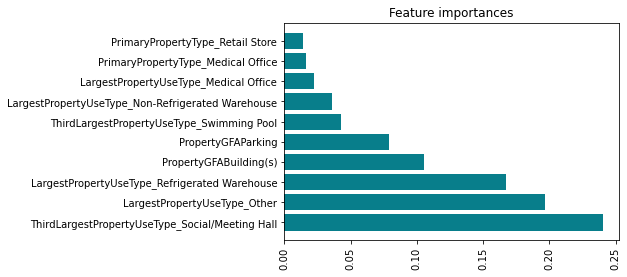

In [20]:
plt.barh(best_features_with_energy['Variable'], best_features_with_energy['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

In [21]:
importances_with_energy[importances_with_energy['Variable'] == "ENERGYSTARScore"]

,index,Variable,Importance
80,9,ENERGYSTARScore,0.0


In [22]:
# Dans l'état actuel est ce que ma variable influe bcp

import shap
X_importance = final_df_with_energy_score.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']).values
X_importance

array([[ 1.92700000e+03, -9.47449194e-02,  8.49461488e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.99600000e+03, -9.47449194e-02,  7.26136505e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.96900000e+03, -9.47449194e-02,  4.42588600e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.95500000e+03, -9.47449194e-02, -5.07113326e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.92900000e+03, -9.47449194e-02, -3.83788343e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.01500000e+03, -9.47449194e-02, -2.60463360e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [23]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(grid_gboost_with_energy_score.best_estimator_)
shap_values = explainer.shap_values(X_importance)

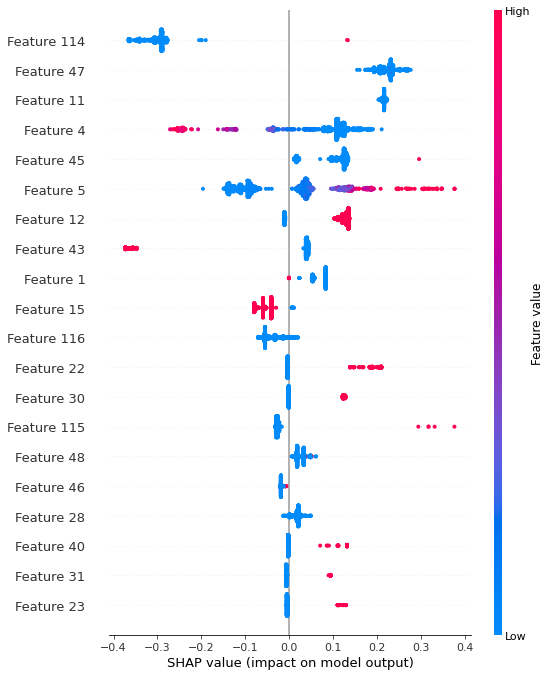

In [24]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

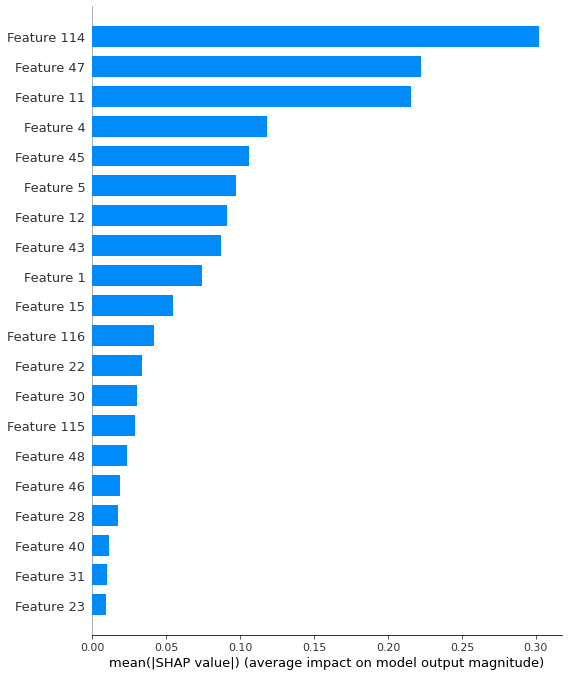

In [25]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')